# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [9]:
"""
Error occurred while loading dataset.
Error Message: ImportError: FloatProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Help from Fady.Ebeid.SessionLead"""
!pip install --upgrade ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: ipywidgets in /root/.local/lib/python3.7/site-packages (8.0.6)


In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
# Define transforms
#Mean and std of the MNIST set was known from 
#https://datascience.stackexchange.com/questions/46228/how-mean-and-deviation-come-out-with-mnist-dataset
batch_size = 40
train_transform = transforms.Compose([transforms.RandomHorizontalFlip()
                                      ,transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# Create training set and define training dataloader
training_set = torchvision.datasets.MNIST(root='data', train = True, transform = train_transform, download =True)
train_data = torch.utils.data.DataLoader(training_set,batch_size=batch_size,shuffle = True)

# Create test set and define test dataloader
testing_set = torchvision.datasets.MNIST(root='data', train = False, transform = test_transform, download =True)
test_data = torch.utils.data.DataLoader(testing_set,batch_size=batch_size)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**Preprocessing** <br>
**transforms.ToTensor()** is used in order to convert numpy array to Tensor. <br>
**transforms.Normalize()** with mean=(0.1307) std=(0.3081) so that (data-mean)/std will create 0 mean and unit standard deviation. <br> 
 **transforms.RandomHorizontalFlip()** to put additional variety of pictures inside the training set

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [6]:
# Explore data
#Creating a train data again without much transformation to view data using show5() function
not_transformed_train_data = torchvision.datasets.MNIST(root='data', train = True, transform = transforms.ToTensor(), download =True)
not_transformed_train_data_loader = torch.utils.data.DataLoader(not_transformed_train_data, batch_size = 32, shuffle = True)

7


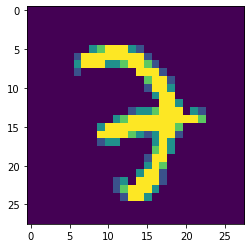

0


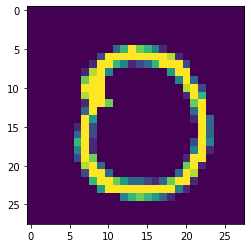

7


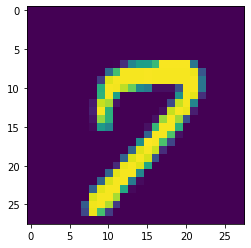

2


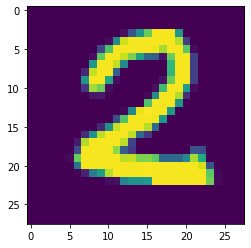

3


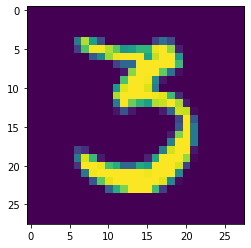

In [7]:
#Showing 5 pictures
show5(not_transformed_train_data_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [8]:
#Checking the size of the input
print("Size of train_data: {}".format(next(iter(train_data))[0].shape))
print("Size of test_data: {}".format(next(iter(test_data))[0].shape))
print("Unique labels/targets: {}".format(training_set.targets.unique()))

Size of train_data: torch.Size([40, 1, 28, 28])
Size of test_data: torch.Size([40, 1, 28, 28])
Unique labels/targets: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


The size of the intput features is 784, which is 28 * 28 (size of an image). <br>
Thus, the input layer will start at 784 nodes.<br>
Unique targets/digit labels are 0 to 9. Thus, the output layer will have 10 output nodes.<br>

In [9]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.flatten(x,1) #Flattening all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiating the model
net = Network()
net.to(device)

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
#Optimizer
optimizer = optim.Adam(net.parameters(),lr=0.001)

#Loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
def train_net(epochs, net, opti, crit, train):
    #Arrays to store training losses and training accuracies
    train_losses, train_acc = [],[]
    
    for epoch in range(epochs):
        print("Training Epoch: {}".format(epoch + 1))
        #Resetting Train and loss and correct every epoch
        net.train()
        train_loss = 0.0
        train_correct = 0
        total_rounds = 0
        for i, data in enumerate(train):
            images, labels = data
            #Passing inputs and labels to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            
            opti.zero_grad()
            outputs = net.forward(images)
            loss = crit(outputs,labels)
            loss.backward()
            opti.step()
            
            #Getting highest probability
            _, preds = torch.max(outputs, dim = 1)
            #Total correct predictions
            train_correct += (preds == labels).sum().item()
            #Total training Loss
            train_loss += loss.item()
            #Calculating accuracy
            """
            Was having trouble with calculating correct accuracy as
            the accuracy was around 38% but the loss is around 0.07.
            After going to slacks, I found a useful reply from Michael Schulze
            that helped me clarify more about the calculation processes and
            finally able to provide "accurate" representation of the "accuracy"
            """
            total_rounds += batch_size
            accuracy = (train_correct/total_rounds)*100
            
        print(f'Epoch {epoch + 1} training accuracy: {accuracy:.2f}% training loss: {train_loss/len(train):.5f}')
        train_losses.append(train_loss/len(train))
        train_acc.append(accuracy)
        
        
    return train_losses, train_acc

In [12]:
epoch = 10
training_losses, training_accuracies = train_net(epoch,net,optimizer,criterion,train_data)

Training Epoch: 1
Epoch 1 training accuracy: 88.27% training loss: 0.36848
Training Epoch: 2
Epoch 2 training accuracy: 94.38% training loss: 0.18091
Training Epoch: 3
Epoch 3 training accuracy: 95.59% training loss: 0.14116
Training Epoch: 4
Epoch 4 training accuracy: 96.26% training loss: 0.11938
Training Epoch: 5
Epoch 5 training accuracy: 96.56% training loss: 0.10807
Training Epoch: 6
Epoch 6 training accuracy: 96.92% training loss: 0.09644
Training Epoch: 7
Epoch 7 training accuracy: 97.20% training loss: 0.08735
Training Epoch: 8
Epoch 8 training accuracy: 97.39% training loss: 0.08078
Training Epoch: 9
Epoch 9 training accuracy: 97.52% training loss: 0.07472
Training Epoch: 10
Epoch 10 training accuracy: 97.86% training loss: 0.06566


Plot the training loss (and validation loss/accuracy, if recorded).

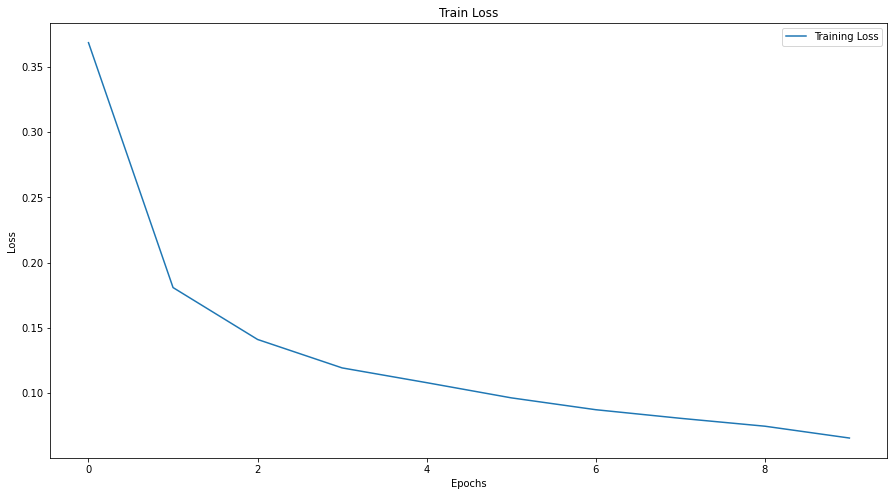

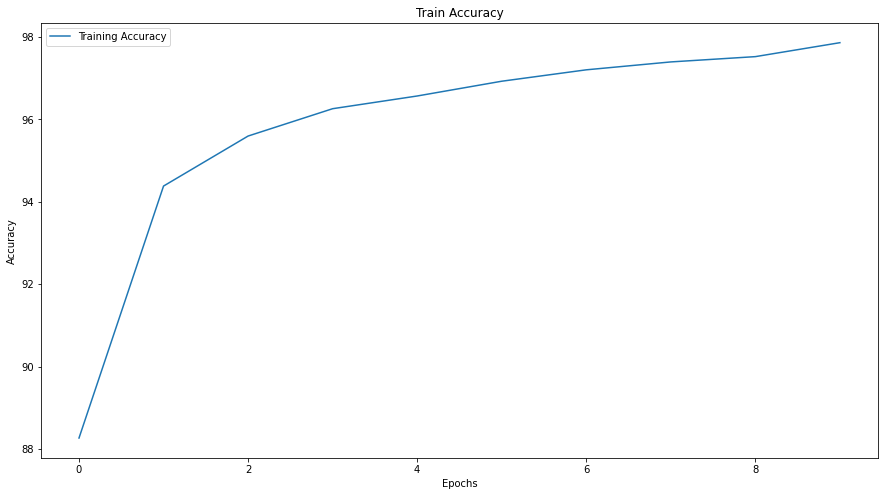

In [13]:
plt.figure(figsize = (15,8))
plt.plot(training_losses, label="Training Loss")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize = (15,8))
plt.plot(training_accuracies, label="Training Accuracy")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
"""Prior to creating separate test function, I integrate this function
into the training function But after reading the above markdown, I separated it.
I realized multiple epochs won't provide any difference on validation accuracy as
it has been already trained. But this will still provide a line on the graph plotted 
below that shows the diffence between validation accuracy and training accuracy"""
def test_net(epochs, net, crit, test):
    #Arrays to store validation losses and validation accuracies
    validation_losses, validation_acc = [],[]
    with torch.no_grad():
        for epoch in range(epochs):
            #Resetting Train and loss and correct every epoch
            val_correct = 0
            val_loss = 0.0
            total_rounds = 0
            net.eval()
            for images, labels in test:
                images = images.to(device)
                labels = labels.to(device)

                outputs = net.forward(images)
                loss = crit(outputs,labels)

                _, preds = torch.max(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_loss += loss.item()
                total_rounds += batch_size
                accuracy = (val_correct/total_rounds)*100
            print(f'Epoch {epoch + 1} validation accuracy: {accuracy:.2f}% validation loss: {val_loss/len(test):.5f}')
            validation_losses.append(val_loss/len(test))
            validation_acc.append(accuracy)
    return validation_losses, validation_acc

In [15]:
validation_losses, validation_accuracies = test_net(epoch,net,criterion,test_data)

Epoch 1 validation accuracy: 96.29% validation loss: 0.12273
Epoch 2 validation accuracy: 96.29% validation loss: 0.12273
Epoch 3 validation accuracy: 96.29% validation loss: 0.12273
Epoch 4 validation accuracy: 96.29% validation loss: 0.12273
Epoch 5 validation accuracy: 96.29% validation loss: 0.12273
Epoch 6 validation accuracy: 96.29% validation loss: 0.12273
Epoch 7 validation accuracy: 96.29% validation loss: 0.12273
Epoch 8 validation accuracy: 96.29% validation loss: 0.12273
Epoch 9 validation accuracy: 96.29% validation loss: 0.12273
Epoch 10 validation accuracy: 96.29% validation loss: 0.12273


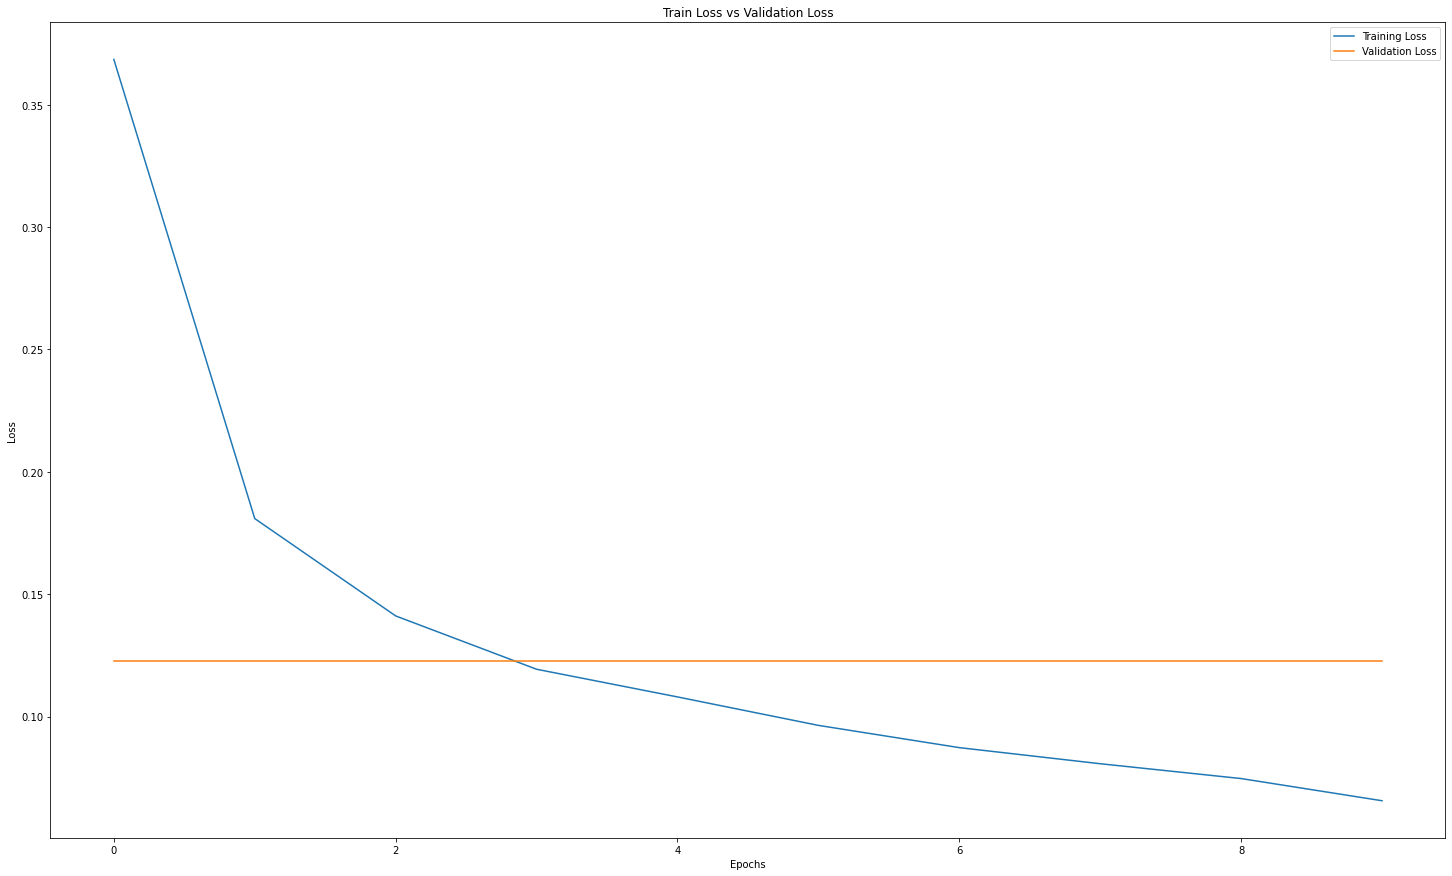

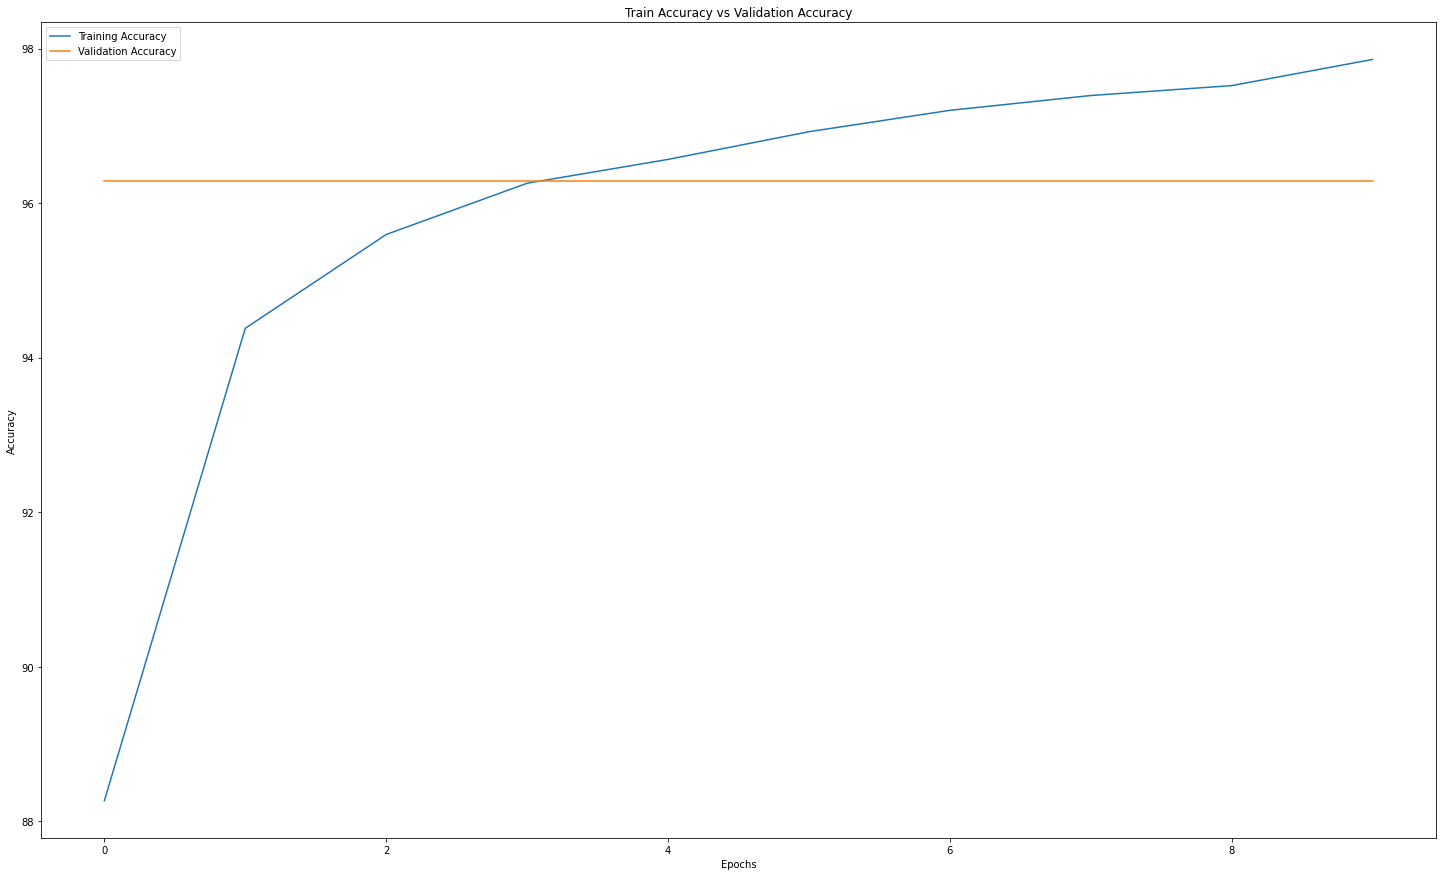

In [16]:
plt.figure(figsize = (25,15))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure(figsize = (25,15))
plt.plot(training_accuracies, label="Training Accuracy")
plt.plot(validation_accuracies, label="Validation Accuracy")
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [17]:
#Adding dropout to the network
class Network_2(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(784, 196)
        self.fc2 = nn.Linear(196, 196)
        self.drop = nn.Dropout(0.5)
        self.fc3 = nn.Linear(196, 49)
        self.fc4 = nn.Linear(49, 10)
        
    def forward(self, x):
        x = torch.flatten(x,1) #Flattening all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiating the model
net_2 = Network_2()
net_2.to(device)

Network_2(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=196, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=196, out_features=49, bias=True)
  (fc4): Linear(in_features=49, out_features=10, bias=True)
)

In [18]:
#SGD Optimizer and additional epoches
optimizer_2 = optim.SGD(net_2.parameters(),lr=0.001)
epoch_2 = 15
training_losses, training_accuracies = train_net(epoch_2,net_2,optimizer_2,criterion,train_data)
validation_losses, validation_accuracies = test_net(epoch_2,net_2,criterion,test_data)

Training Epoch: 1
Epoch 1 training accuracy: 22.67% training loss: 2.27295
Training Epoch: 2
Epoch 2 training accuracy: 39.42% training loss: 2.11777
Training Epoch: 3
Epoch 3 training accuracy: 58.20% training loss: 1.58376
Training Epoch: 4
Epoch 4 training accuracy: 73.76% training loss: 0.96581
Training Epoch: 5
Epoch 5 training accuracy: 77.31% training loss: 0.74302
Training Epoch: 6
Epoch 6 training accuracy: 79.12% training loss: 0.66110
Training Epoch: 7
Epoch 7 training accuracy: 80.30% training loss: 0.61848
Training Epoch: 8
Epoch 8 training accuracy: 81.26% training loss: 0.58800
Training Epoch: 9
Epoch 9 training accuracy: 82.09% training loss: 0.56320
Training Epoch: 10
Epoch 10 training accuracy: 82.89% training loss: 0.54032
Training Epoch: 11
Epoch 11 training accuracy: 83.66% training loss: 0.51920
Training Epoch: 12
Epoch 12 training accuracy: 84.33% training loss: 0.49950
Training Epoch: 13
Epoch 13 training accuracy: 84.99% training loss: 0.47925
Training Epoch: 1

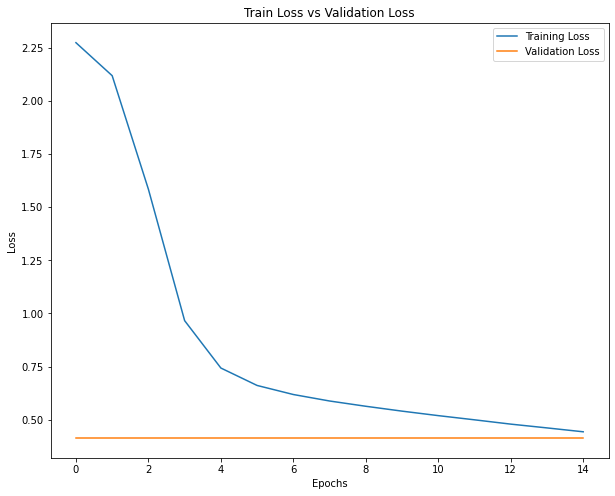

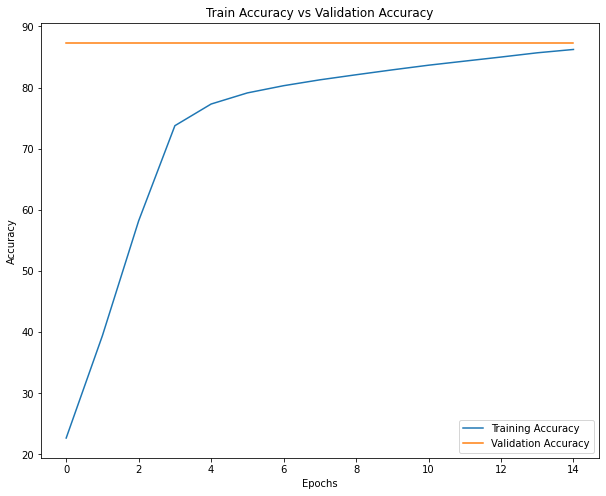

In [19]:
plt.figure(figsize = (10,8))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize = (10,8))
plt.plot(training_accuracies, label="Training Accuracy")
plt.plot(validation_accuracies, label="Validation Accuracy")
plt.title("Train Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Saving your model
Using `torch.save`, save your model for future loading.

In [20]:
torch.save(net_2.state_dict(), 'model_2.pth')

In [21]:
torch.save(net.state_dict(), 'model.pth')